In [2]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3770, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3770 (delta 2), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3770/3770), 143.05 MiB | 37.06 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (3840/3840), done.


**IMPORTING SUFFICIENT LIBRARIES AND MODULES**

In [23]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from imutils.video import VideoStream
import numpy as np
import pandas as pt
import matplotlib.pyplot as plt
import imutils
import time
import cv2
import os


In [24]:
prototxtpath = r"/content/Face-Mask-Detection/face_detector/deploy.prototxt"
weightspath = r"/content/Face-Mask-Detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtpath, weightspath)

In [25]:
MaskNet = load_model("/content/mask_detector.keras")

**STARTING VIDEO STREAM**

In [27]:
vs= VideoStream(src=0).start()  # src is nource that is number of cameras or to which camera r we assigning task. here we have only one camera so we initialise src to 0
#start() function starts the Videostream module



In [28]:
def detect_and_predict_mask(frame,faceNet,maskNet):

  (h,w) = frame.shape[:2]# extracting the eight and weight of the frame

  blob = cv2.dnn.blobFromImage(frame,1.0,(224,224),(104.0,177.0,123.0))
  faceNet.setInput(blob)
  detections = faceNet.forward()
  print(detections.shape)

  faces = []  #initialising empty face, locs and preds lists
  locs = []
  preds = []

  for i in range(0, detections.shape[2]):
    confidence = detections[0,0,i,2]

    if confidence > 0.5:
      box = detections[0,0,i,3:7]*np.array([w,h,w,h])
      (startX, startY, endX, endY) = box.astype("int")
      (startX,startY) = (max(0,startX),max(0,startY))
      (endX,endY)= (min(w-1 , endX),min(h-1,endY))

      face = frame[startY:endY , startX:endX]
      face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
      face = cv2.resize(face,(224,224))
      face = img_to_array(face)
      face = preprocess_input(face)

      faces.append(face)
      locs.append((startX, startY, endX, endY))

  if len(faces)> 0:
    faces = np.array(faces, dtype = "float32")
    preds = maskNet.predict(faces,batch_size = 32)

  return (locs,preds)


In [30]:
#while frame : #reading images(video) in the frame
  #img = cv2.imread('/content/mask-4898571_640.jpg')

frame = cv2.imread('/content/download.jpeg')
frame = imutils.resize(frame , width = 400)

# now we have three variables i.e FaceNet, MaskNet , frame
#FaceNet is for face prediction, Masknet is for Mask predction on face, frame for video loading from the camera
(locs,preds) = detect_and_predict_mask(frame,faceNet,MaskNet)
#locs : location of particular rectangle surrounding the face , pred  predictions

  #TUPLE UNPACKING
for (box,pred) in zip(locs,preds):
  (startX, startY, endX, endY) = box #stasrtX = x1, startY = y1, endX = x2, endY = y2
  (mask,withoutMask) = pred
  label = "Mask" if mask>withoutMask else "No Mask"    #setting labels
  color = (0,255,0) if label == "Mask" else (0,0,255)
  # color encoding : here we use BGR as (0,255,0) means G for Green is the color chosen to the boxes id mask is present and red when there is no mask as in (0,0,255)
  #including probability in the label
  label = "{}:{:.2f}%".format(label,max(mask,withoutMask)*100)
                 #output the labels
  cv2.putText(frame,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45, color, 2)# startY is subtrated 10 pixels so that it does  noe overlab the startX value
                  # OUTPT OF THE FRAME
  # defining the font as Hershey_Simplex,
  cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)  #2 : thickness of the rectangle
#cv2_imshow(frame)# command to show output cv2_imshow works only on colab and not  universally
cv2.imwrite('/content/1.png', frame) # used to save an image
#key = cv2.waitKey(1)& 0xFF # not required in colab
#if key == ord("q"):
#  break

(1, 1, 200, 7)
1/1 [==============================] - 3s 3s/step


True

In [31]:
cv2.destroyAllWindows()
vs.stop()

In [ ]:
# CODE FOR MODEL

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D , Dropout , Flatten , Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing  import LabelBinarizer
from sklearn.model_selection import  train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# preprocessing

In [5]:
# define directory with the datapath where the folder is present
DIRECTORY = r"/content/Face-Mask-Detection/dataset"
CATEGORIES = ["with_mask", "without_mask"] # with_mask and without_mask are the folders inside Directory not stored in list names CATEGORIES

In [6]:
# create two empty lists  of data and labels
data = []
labels = []

In [7]:
# looping through categories
for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category)# first looping through with_mask then through without_mask in order to get the path of with_mask and without_mask
  for img in os.listdir(path): #listdir function listes down all images in the particular directory
    img_path = os.path.join(path,img)# join the patahs of the particular with_mask to the corresponding image followed my without_mask to the corresponding image
    image = load_img(img_path, target_size= (224,224)) # target size gives the height and width of the image, converting all the images to target sizeto amke them uniform
    image = img_to_array(image)
    image = preprocess_input(image) #we'll be using mobilenet model, whenever we needto use mobile net, we need to preprocess  input

    data.append(image)
    labels.append(category) # category : with_mask , without_mask
 #data list contains numerical values, labels : alphabetic values i.e with_mask, without_mask


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


data list contains numerical values, labels : alphabetic values i.e with_mask, without_mask

To change alphabetic values of labels into numberic, we use labelBinarizer model

hence we'll fit the labels list to this model

In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
#convert the data and labels to numpy arrays
data = np.array(data, dtype = "float32")
label=  np.array(labels)

In [10]:
#dividing the data into train, test and split folder
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2, random_state = 50)

TRAINING

In [11]:
#set initial learning rate: it should be less, epochs and batch size
LR = 1e-4 #learning rate
EPOCHS = 20
BatchSize = 96

In [12]:
#data Augmentation
aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest"
)

In [13]:
#Modeling
baseModel = MobileNetV2(weights = "imagenet", include_top = False , input_tensor = Input(shape=(224,224,3)))
# imagenet : pretrained mmodel for images with better weights for better results
#include_top : wheter include fullyy connected layer at the top of our network
#input_tensor : shape of the image the model is going through , here 224,224 is image size and 3 is number of input channels
#coloured images have 3 channels : R,G,B

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
#constructing our fully connected layer by using pooling stuffs
headmodel = baseModel.output
headmodel = AveragePooling2D(pool_size =(7,7))(headmodel)
headmodel = Flatten(name = "flatten")(headmodel)
headmodel = Dense(128,activation = "relu")(headmodel) #dense layer is 128 neurons, relu is used for non linear used cases i.e in mostly image data , we use relu activation fnction INPUT LAYER
headmodel = Dropout(0.5)(headmodel)# to avoid overfitting
headmodel = Dense(2,activation = "softmax")(headmodel)# OUTPUT LAYER consists of two layers: with_mask, without_mask ,, Activation :softmax as  it gives probability based 0s and 1s values

model = Model(inputs = baseModel.input , outputs = headmodel) # final model on which we'll work

In [15]:
# we need to freeze the initial layers in the base model so that they will not be updated in the first training process
for layer in baseModel.layers:
  layer.trainable = False

In [16]:
#compiling model
print("compiling model ....")
# we're using Adam optimizer
opt = Adam(learning_rate = LR)
model.compile(loss = "binary_crossentropy",optimizer=opt,metrics = ["accuracy"])

compiling model ....


In [17]:
#training model
H = model.fit(aug.flow(trainX,trainY, batch_size = BatchSize), steps_per_epoch=len(trainX)//BatchSize,
              validation_data = (testX, testY),validation_steps= len(testX)//BatchSize, epochs = EPOCHS)

Epoch 1/20
31/31 [==============================] - 62s 2s/step - loss: 0.6067 - accuracy: 0.7394 - val_loss: 0.3323 - val_accuracy: 0.9492
Epoch 2/20
31/31 [==============================] - 42s 1s/step - loss: 0.2996 - accuracy: 0.9259 - val_loss: 0.1897 - val_accuracy: 0.9661
Epoch 3/20
31/31 [==============================] - 43s 1s/step - loss: 0.1938 - accuracy: 0.9502 - val_loss: 0.1319 - val_accuracy: 0.9739
Epoch 4/20
31/31 [==============================] - 43s 1s/step - loss: 0.1469 - accuracy: 0.9630 - val_loss: 0.1051 - val_accuracy: 0.9765
Epoch 5/20
31/31 [==============================] - 42s 1s/step - loss: 0.1198 - accuracy: 0.9727 - val_loss: 0.0868 - val_accuracy: 0.9817
Epoch 6/20
31/31 [==============================] - 43s 1s/step - loss: 0.1016 - accuracy: 0.9731 - val_loss: 0.0772 - val_accuracy: 0.9831
Epoch 7/20
31/31 [==============================] - 43s 1s/step - loss: 0.0901 - accuracy: 0.9778 - val_loss: 0.0687 - val_accuracy: 0.9804
Epoch 8/20
31/31 [==

MAKING PREDICTIONS

In [18]:
predIds = model.predict(testX, batch_size = BatchSize) #evaluating model
predIds = np.argmax(predIds, axis = 1) #to find index of the label to get hte highest predicted probability
print(classification_report(testY.argmax(axis=1), predIds, target_names = lb.classes_))

8/8 [==============================] - 3s 258ms/step
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       377
without_mask       0.99      0.98      0.99       390

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [19]:
#saving the generated model
model.save("mask_detector.keras" , save_format= "h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
#plotting training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")


In [21]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

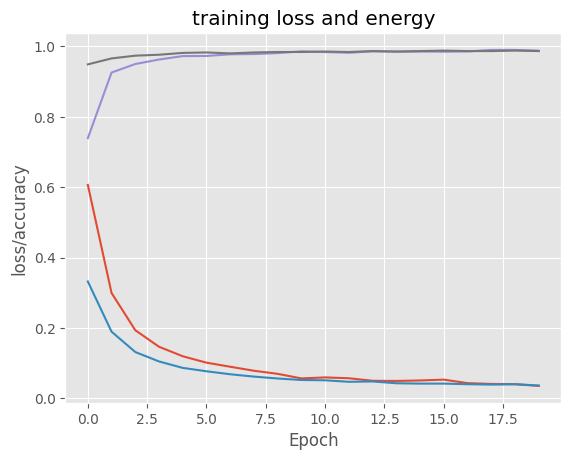

In [22]:
plt.plot(np.arange(0,N), H.history["loss"],label = "train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"],label = "val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"],label = "train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"],label = "val_acc")
plt.title("training loss and energy")
plt.xlabel("Epoch")
plt.ylabel("loss/accuracy")
#plt.legend(LOC = "lower left")
plt.savefig("plot.png")